In [1]:
import seaborn as sns  # Add at the top with other imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import psutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.fftpack import fft
import warnings

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')

# ============================================
# 1. Data Loading and Preprocessing
# ============================================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    df.columns = df.columns.str.replace('"', '').str.strip()

    if 'TIME' not in df.columns:
        raise KeyError("The column 'TIME' does not exist in the dataset.")

    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)

    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)

    target_col = 'fenologia_h2'
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")

    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1

    

    df.fillna(df.median(), inplace=True)
    return df, target_col

# ============================================
# 2. Feature Scaling
# ============================================
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 3D for RNN
    return X_scaled, y, scaler

# ============================================
# 3. Build GRU Model
# ============================================
def build_gru_model(input_shape, num_classes=4, num_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(num_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ============================================
# 4. Bayesian Optimization Objective
# ============================================
def objective_function(num_units, dropout_rate, epochs, batch_size, X_train, y_train):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(num_units),
        dropout_rate=dropout_rate
    )
    history = model.fit(
        X_train, y_train,
        epochs=int(epochs),
        batch_size=int(batch_size),
        validation_split=0.2,
        verbose=0
    )
    return np.max(history.history['val_accuracy'])

# ============================================
# 5. Optimize Hyperparameters
# ============================================
def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'epochs': (50, 100),
        'batch_size': (16, 64)
    }

    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, epochs, batch_size: objective_function(
            num_units, dropout_rate, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=15)
    return optimizer.max['params']

# ============================================
# 6. Train & Evaluate Model
# ============================================
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    model = build_gru_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_classes=4,
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate'])
    )

    start_train = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )
    training_time = time.time() - start_train

    start_infer = time.time()
    y_pred = model.predict(X_test).argmax(axis=1)
    inference_time = (time.time() - start_infer) / len(X_test)

    # Calculate total testing time
    testing_time = time.time() - start_infer

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("\n===== Evaluation =====")
    print(f"Accuracy: {acc:.4f}")
    print("Report:\n", classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", cm)

    model.save("temp_model.h5", include_optimizer=False)
    model_size = os.path.getsize("temp_model.h5") / (1024 ** 2)
    os.remove("temp_model.h5")

    total_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    ram_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 ** 2)

    print("\n===== Model Metrics =====")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Inference/sample: {inference_time:.6f}s")
    print(f"Testing Time: {testing_time:.2f}s")
    print(f"Model Size: {model_size:.2f} MB")
    print(f"Trainable Params: {total_params:,}")
    print(f"RAM Usage: {ram_usage:.2f} MB")

    return model, history

def plot_correlation_heatmap(df, target_col):
    # Drop non-numeric or target column for feature-only correlation
    features_df = df.drop(columns=[target_col], errors='ignore')

    # Compute correlation matrix
    corr_matrix = features_df.corr()

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
    plt.title("Feature Correlation Heatmap", fontsize=16)
    plt.tight_layout()
    plt.show()

def main():
    train_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
    test_path = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\test_lasso_selected.csv"

    df_train, target_col = load_and_preprocess_data(train_path)

    # 🔥 Plot correlation heatmap for Explainability
    print("\nGenerating Feature Correlation Heatmap...")
    plot_correlation_heatmap(df_train, target_col)

    X_train, y_train, _ = feature_scaling(df_train, target_col)

    df_test, _ = load_and_preprocess_data(test_path)
    X_test, y_test, _ = feature_scaling(df_test, target_col)

    print("\n Optimizing Hyperparameters...")
    best_params = optimize_hyperparameters(X_train, y_train)
    print("\n Best Params:", best_params)

    print("\n Training Final GRU Model...")
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params)


Generating correlation heatmap...


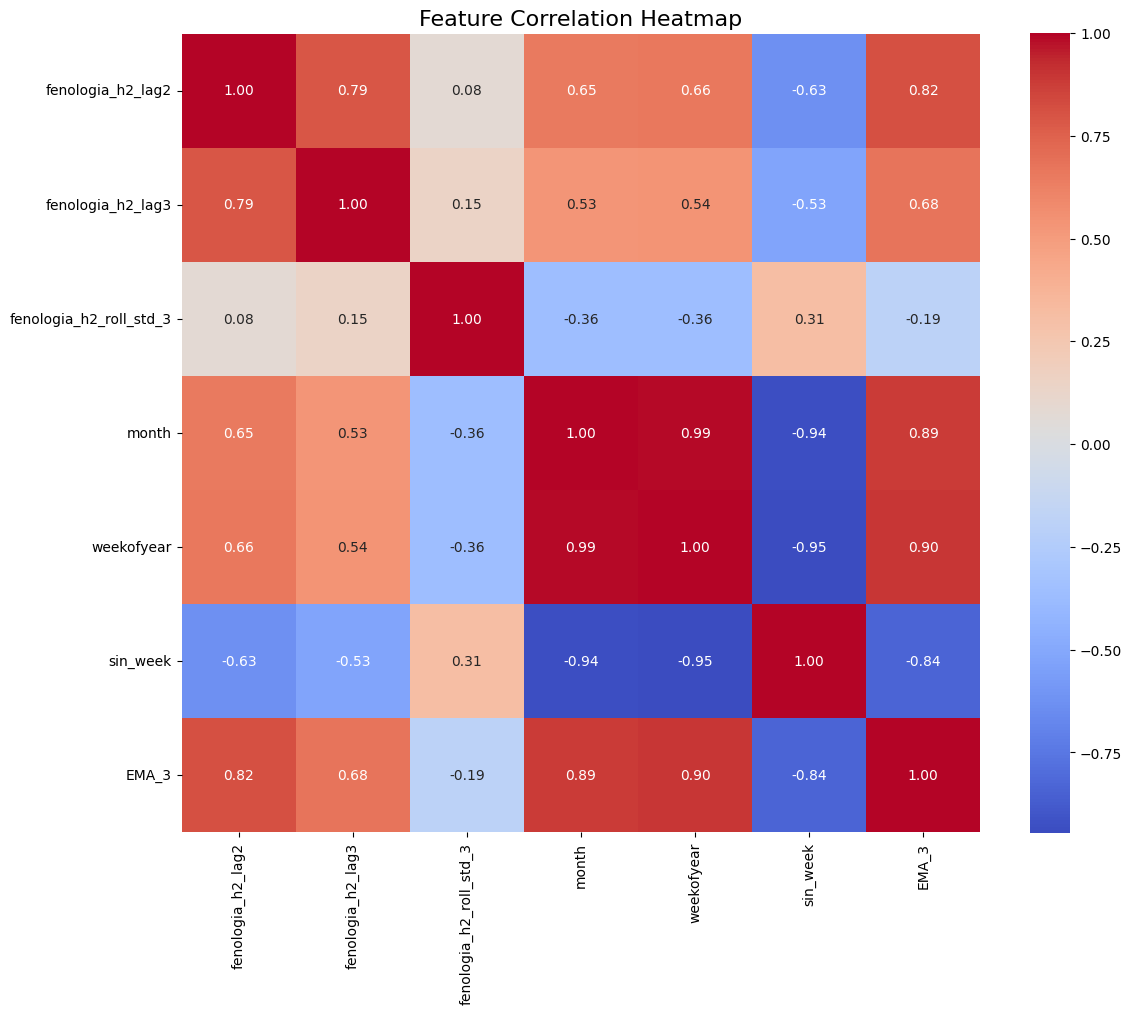

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def load_and_preprocess_data(filepath):
    # Load CSV
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    # Clean column names
    df.columns = df.columns.str.replace('"', '').str.strip()
    
    # Check for TIME column and parse it if exists
    if 'TIME' in df.columns:
        df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
        df.dropna(subset=['TIME'], inplace=True)
        df.set_index('TIME', inplace=True)
    
    # Convert all columns to numeric if possible
    df = df.apply(pd.to_numeric, errors='coerce')
    # Drop columns with all NaNs
    df.dropna(axis=1, how='all', inplace=True)
    
    target_col = 'fenologia_h2'
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")
    
    # Fill missing values in target with interpolation
    df[target_col].interpolate(method='linear', inplace=True)
    df[target_col] = df[target_col] - 1  # Adjust target if needed
    
    # Fill remaining NaNs with median values
    df.fillna(df.median(), inplace=True)
    
    return df, target_col

def plot_correlation_heatmap(df, target_col):
    # Select only numeric columns excluding target
    features_df = df.drop(columns=[target_col], errors='ignore')
    features_df = features_df.select_dtypes(include=['number'])
    
    # Compute correlation matrix
    corr_matrix = features_df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
    plt.title("Feature Correlation Heatmap", fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Replace this path with your actual CSV path
    filepath = r"E:\Abroad period research\Phenology datasets\Lasso_Selected_Features_H2\train_lasso_selected.csv"
    
    # Load and preprocess data
    df, target_col = load_and_preprocess_data(filepath)
    
    # Plot correlation heatmap
    print("Generating correlation heatmap...")
    plot_correlation_heatmap(df, target_col)
